In [10]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from uk_road_safety.python.data_cleaning import prepare_data_for_groupby
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/preprocessed-1999-2021.csv')

In [12]:
df_accidents['date']=pd.to_datetime(df_accidents['date'])

# First Geohash gcpvj0

In [11]:
test_max_square=df_accidents[df_accidents['geohash']=='gcpvj0']
time_series=data_for_analysis(test_max_square,'W')

In [13]:
FOLD_LENGTH=208 #each fold spans over 4 years
FOLD_STRIDE=52 #we have a fold every 1 year
INPUT_LENGTH=10 #every X_i sequence is 10 weeks long
TRAIN_TEST_RATIO=.80 #in each fold, we use 3 years for training and 1 year for test
OUTPUT_LENGTH=10 #we want to predict the number of accidents in the next 10 weeks (y_i length)
SEQUENCE_STRIDE = 1

In [30]:
folds=mlmodel.get_folds(time_series,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(20, 208, 1)

In [52]:
fold=folds[-1]

In [53]:
(fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold_train.shape

(166, 1)

In [54]:
X_train, y_train = mlmodel.get_X_y_strides(fold_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test, y_test = mlmodel.get_X_y_strides(fold_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [77]:
model = mlmodel.init_model(X_train)
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 120)           58560     
                                                                 
 dense_72 (Dense)            (None, 10, 20)            2420      
                                                                 
 dropout_48 (Dropout)        (None, 10, 20)            0         
                                                                 
 dense_73 (Dense)            (None, 10, 10)            210       
                                                                 
 dropout_49 (Dropout)        (None, 10, 10)            0         
                                                                 
 dense_74 (Dense)            (None, 10, 1)             11        
                                                                 
Total params: 61,201
Trainable params: 61,201
Non-tra

In [78]:
model, history = mlmodel.fit_model(model,X_train,y_train)

Epoch 1/100
4/4 [==============================] - 6s 272ms/step - loss: 76.8909 - mae: 5.1947 - val_loss: 1.2993 - val_mae: 0.9286
Epoch 2/100
4/4 [==============================] - 0s 43ms/step - loss: 1.9925 - mae: 1.1335 - val_loss: 1.1818 - val_mae: 0.8015
Epoch 3/100
4/4 [==============================] - 0s 42ms/step - loss: 2.2420 - mae: 1.1805 - val_loss: 1.2223 - val_mae: 0.9541
Epoch 4/100
4/4 [==============================] - 0s 43ms/step - loss: 1.9960 - mae: 1.1053 - val_loss: 1.1420 - val_mae: 0.8910
Epoch 5/100
4/4 [==============================] - 0s 45ms/step - loss: 1.9528 - mae: 1.1248 - val_loss: 1.1989 - val_mae: 0.9549
Epoch 6/100
4/4 [==============================] - 0s 43ms/step - loss: 1.8909 - mae: 1.0790 - val_loss: 1.1296 - val_mae: 0.8991
Epoch 7/100
4/4 [==============================] - 0s 43ms/step - loss: 1.8430 - mae: 1.1028 - val_loss: 1.2480 - val_mae: 1.0025
Epoch 8/100
4/4 [==============================] - 0s 46ms/step - loss: 1.7594 - mae: 1.

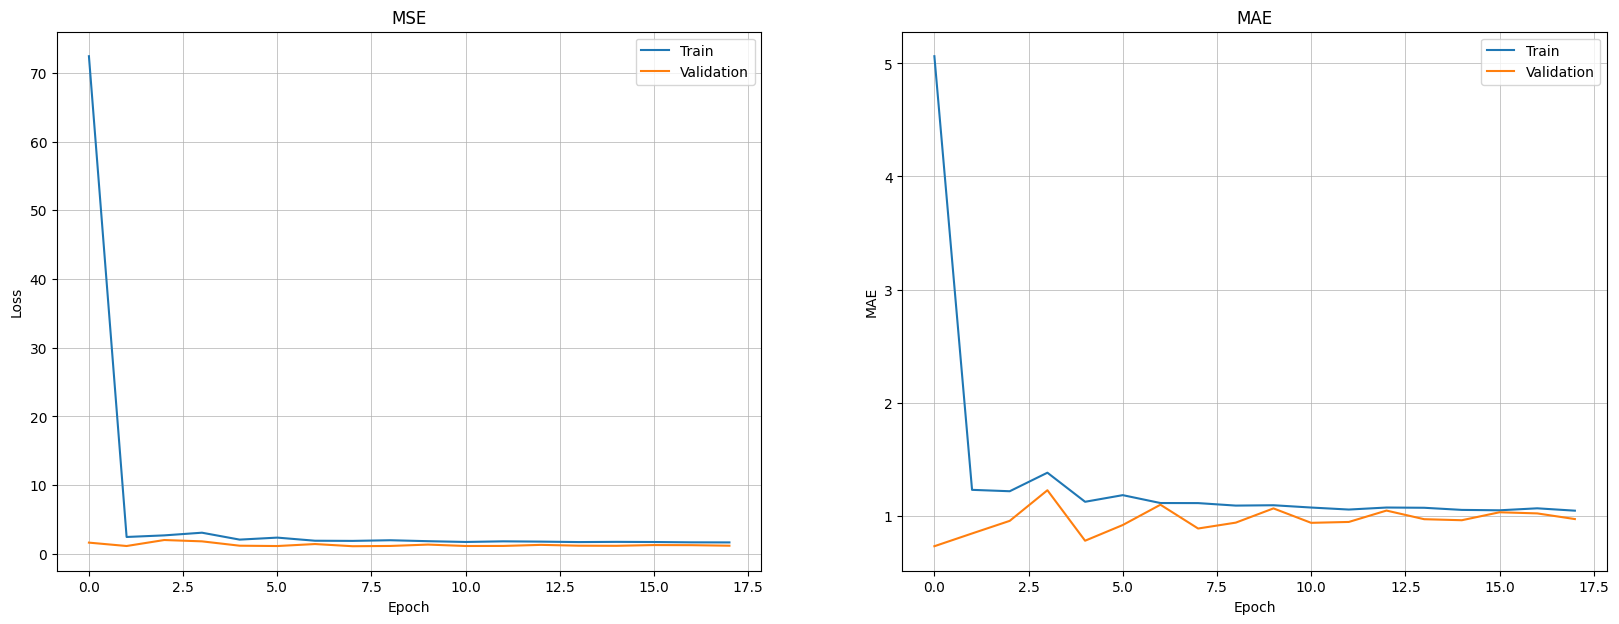

In [57]:
mlmodel.plot_history(history);

In [58]:
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test, y_test)
res=model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 12ms/step - loss: 0.7974 - mae: 0.7148


In [59]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 0.71 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 21.64 %


In [39]:
mae_baselines, mae_lstms = mlmodel.cross_validate_baseline_and_lstm(time_series,FOLD_LENGTH, FOLD_STRIDE,
                                     TRAIN_TEST_RATIO, INPUT_LENGTH,
                                     OUTPUT_LENGTH, SEQUENCE_STRIDE)

20
--------------------------------------------------
MAE baseline fold n°0 = 1.48
MAE LSTM fold n°0 = 1.18
Improvement over baseline: 20.3 % 

--------------------------------------------------
MAE baseline fold n°1 = 1.73
MAE LSTM fold n°1 = 1.12
Improvement over baseline: 35.42 % 

--------------------------------------------------
MAE baseline fold n°2 = 1.58
MAE LSTM fold n°2 = 1.06
Improvement over baseline: 33.06 % 

--------------------------------------------------
MAE baseline fold n°3 = 1.16
MAE LSTM fold n°3 = 1.04
Improvement over baseline: 10.77 % 

--------------------------------------------------
MAE baseline fold n°4 = 1.19
MAE LSTM fold n°4 = 0.94
Improvement over baseline: 20.96 % 

--------------------------------------------------
MAE baseline fold n°5 = 1.21
MAE LSTM fold n°5 = 0.88
Improvement over baseline: 27.79 % 

--------------------------------------------------
MAE baseline fold n°6 = 1.58
MAE LSTM fold n°6 = 1.09
Improvement over baseline: 31.51 % 

----

In [40]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - np.array(mae_lstms)/np.array(mae_baselines)),2)*100}%")

➡ Average percentage improvement over baseline = 18.0%


2/2 [==============================] - 0s 4ms/step


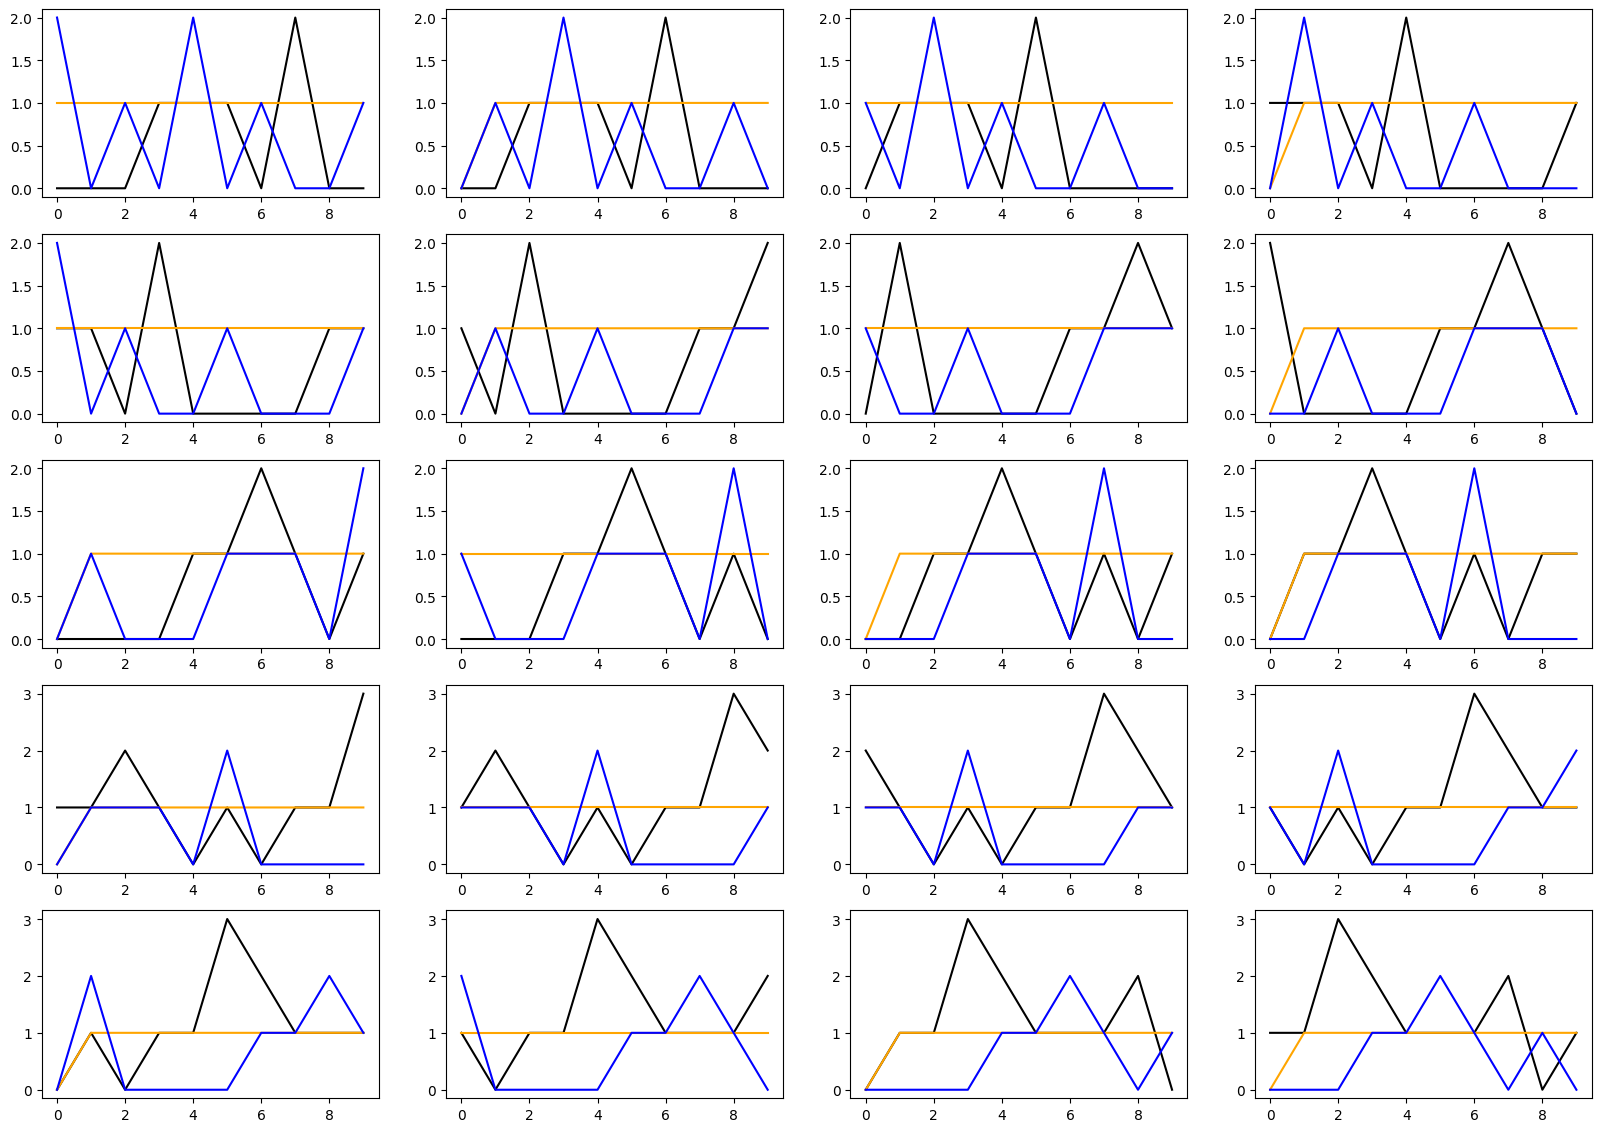

In [79]:
y_pred=model.predict(X_test)
y_bas_pred=baseline_model.predict(X_test)
mlmodel.plot_predictions(y_test, y_pred, y_bas_pred)

In [89]:
X=X_test[-1]
csv_path = '../notebooks/data'
np.save(os.path.join(csv_path,'X_gcpvj0.npy'), X)

In [93]:
model_loaded = tf.keras.models.load_model('API/model/gcpvj0_')
X_api = np.load('../notebooks/data/X_gcpvj0.npy')
y_pred_loaded = np.round(np.array(model_loaded.predict([X_api]))).reshape(10,1)
y_pred_loaded

1/1 [==============================] - 0s 470ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

# Procedure that generates one model per geohash

In [16]:
df_accidents_2021=df_accidents[df_accidents['accident_year']==2021]
hashes_2021=df_accidents[['accident_year','geohash']].groupby('geohash').count()
hashes_2021.columns=['Accidents']
hashes_2021.sort_values('Accidents',inplace=True,ascending=False)

In [17]:
geohash_list=hashes_2021.head().index
geohash_list

Index(['gcpvj0', 'gcpvhc', 'gcpvj4', 'gcpvj1', 'gcpuv2'], dtype='object', name='geohash')

******
 Initiating procedure on geohash gcpvj0
 ******
2/2 [==============================] - 0s 14ms/step - loss: 1.0000 - mae: 0.9121
The LSTM MAE on the test set is equal to 0.69 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :24.49 %
2/2 [==============================] - 0s 5ms/step


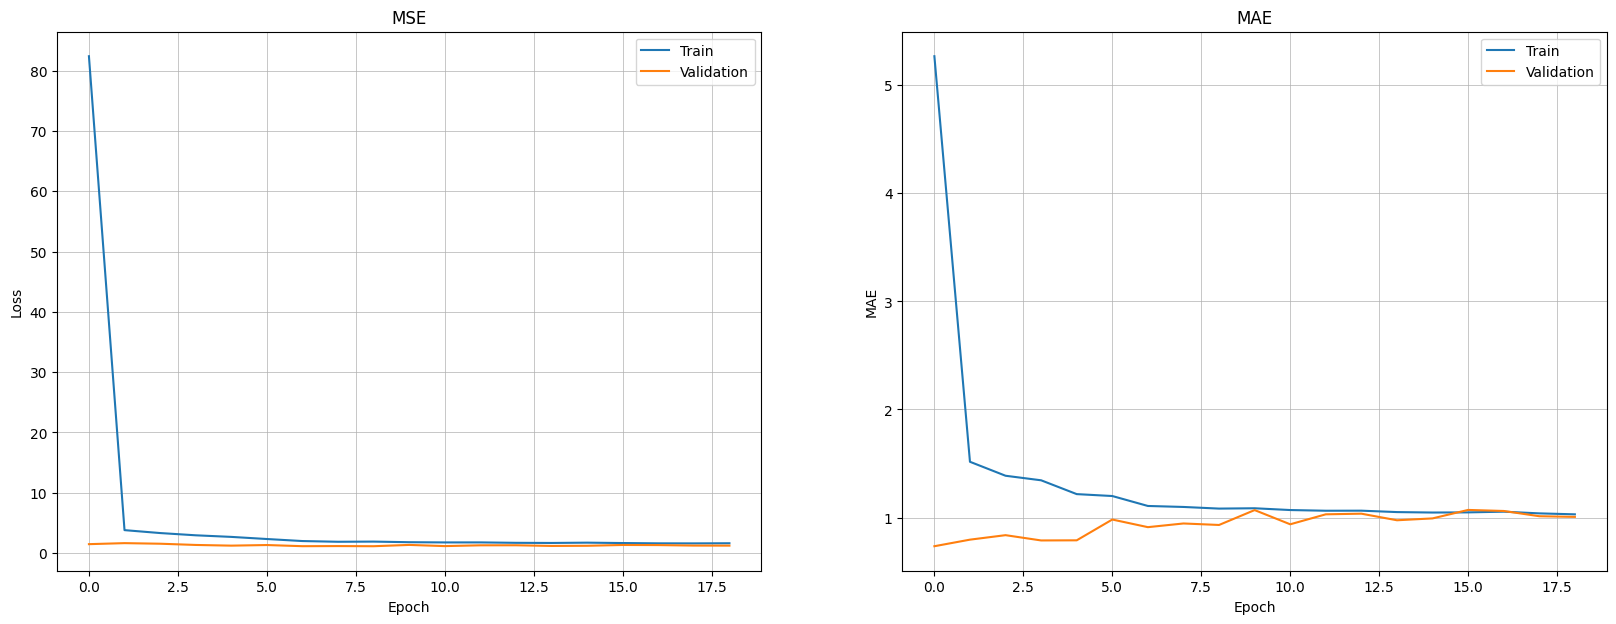

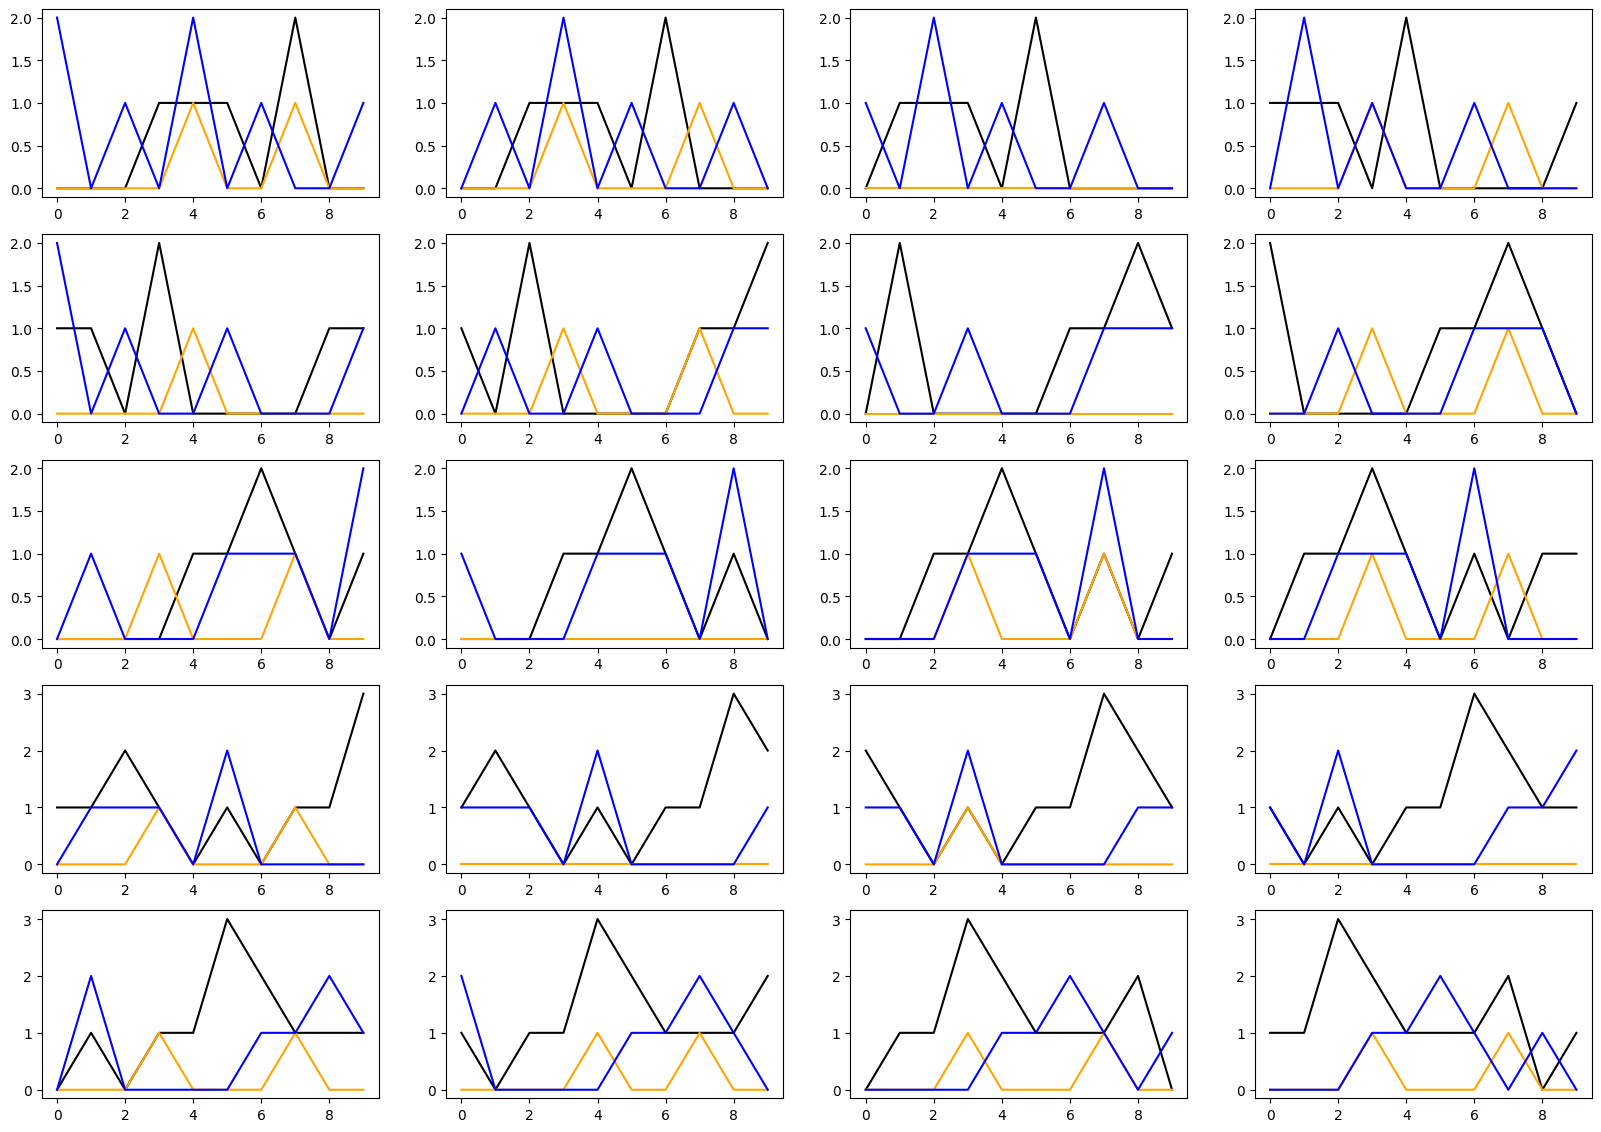

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj0/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj0/assets


******
 Initiating procedure on geohash gcpvhc
 ******
2/2 [==============================] - 0s 8ms/step - loss: 1.0000 - mae: 0.8364
The LSTM MAE on the test set is equal to 0.82 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :1.81 %
2/2 [==============================] - 0s 3ms/step


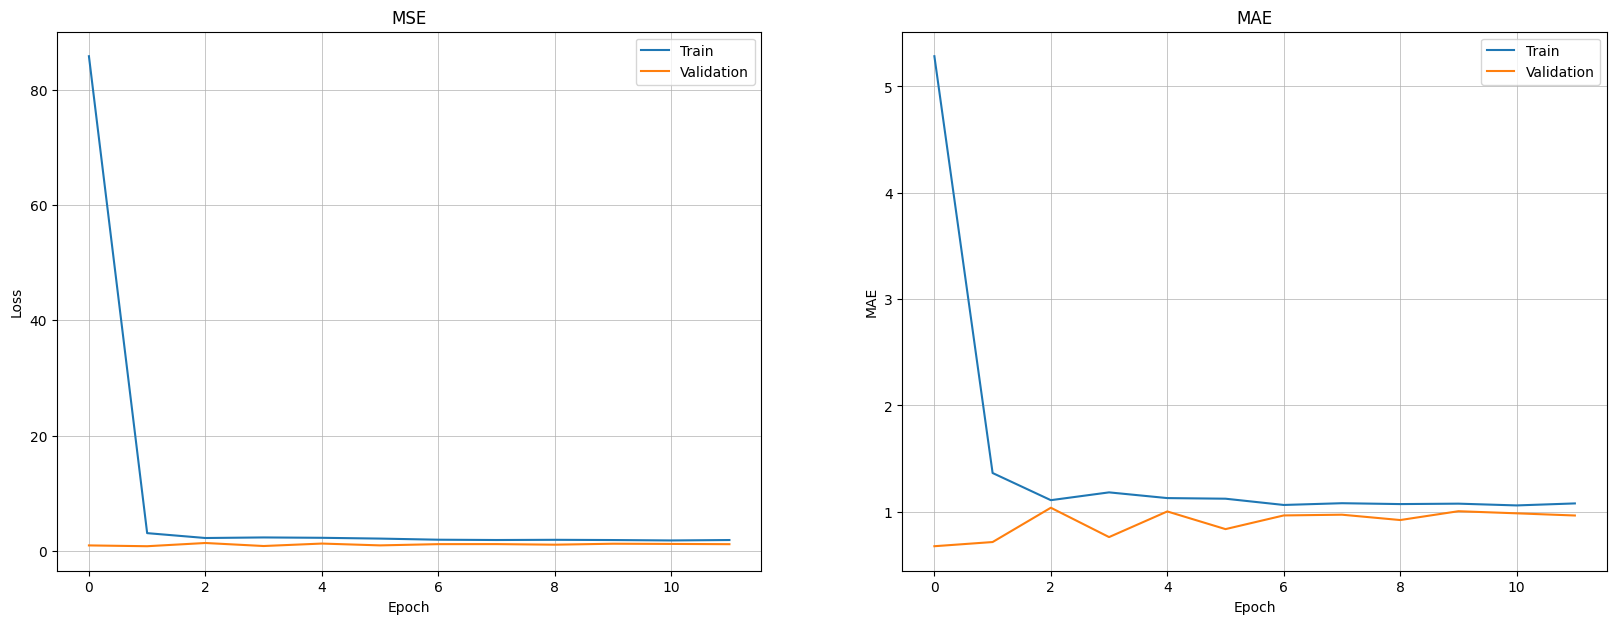

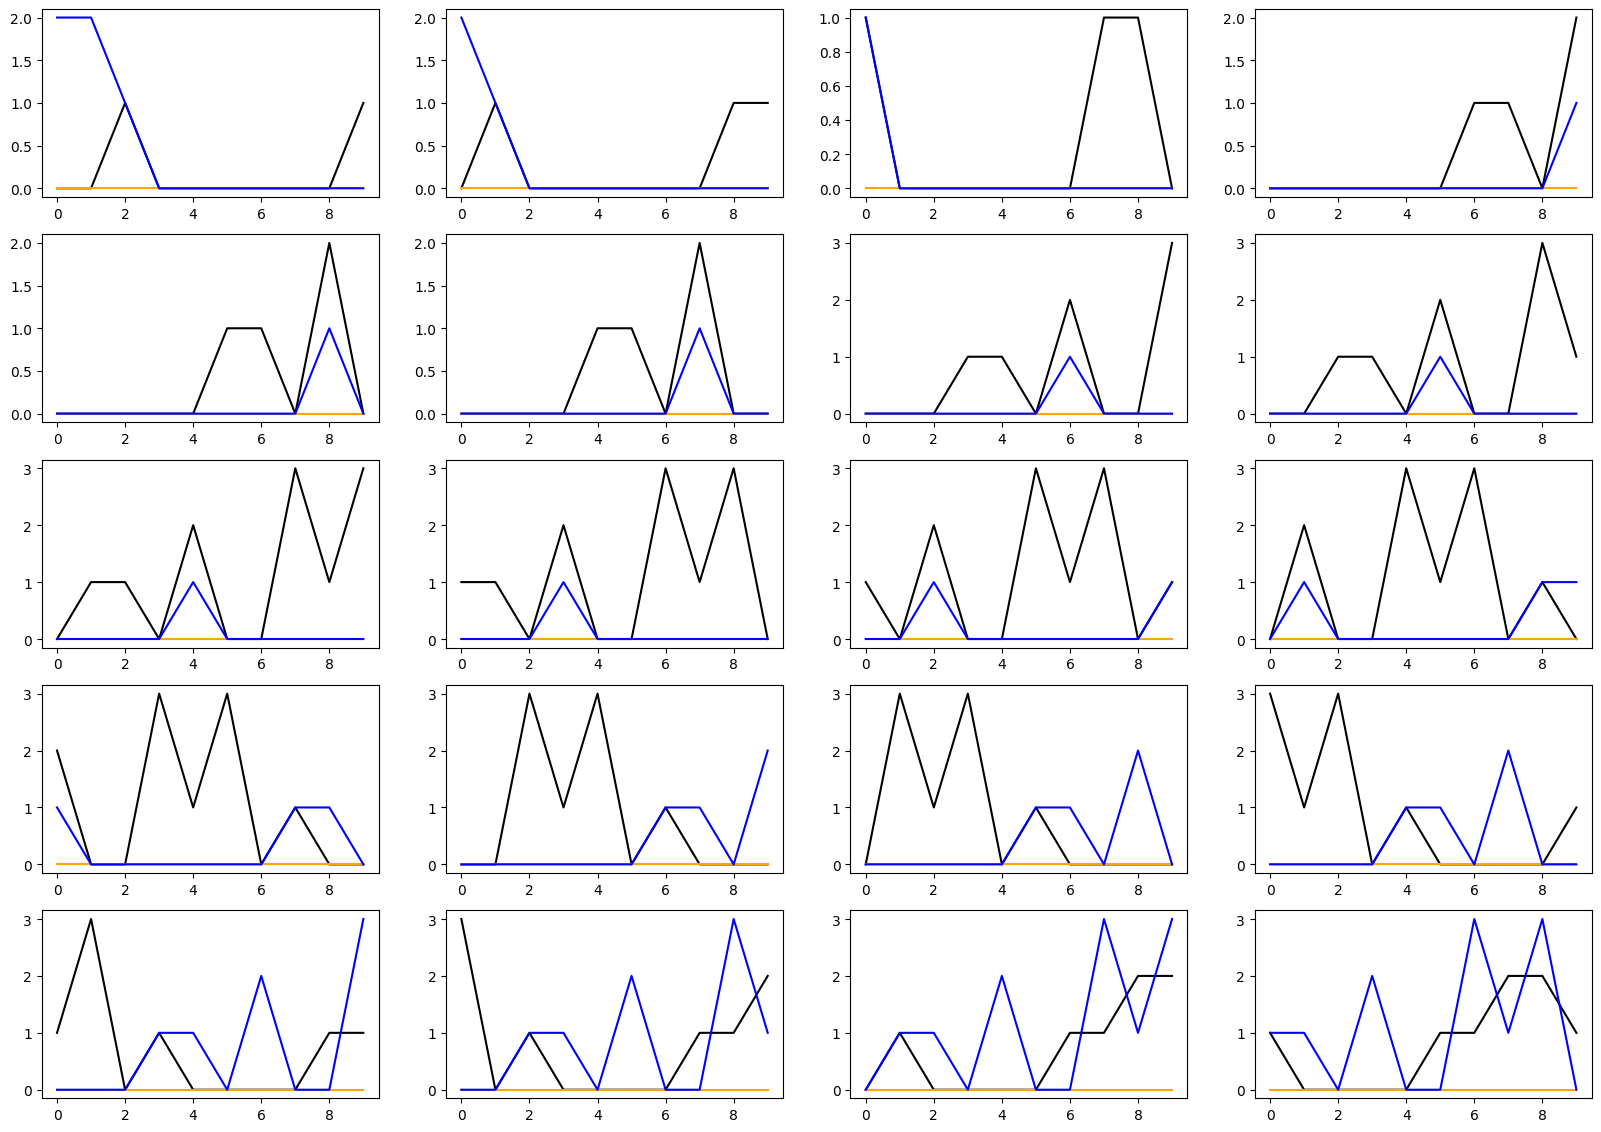

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvhc/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvhc/assets


******
 Initiating procedure on geohash gcpvj4
 ******
2/2 [==============================] - 0s 11ms/step - loss: 1.0000 - mae: 1.0030
The LSTM MAE on the test set is equal to 0.81 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :19.49 %
2/2 [==============================] - 0s 3ms/step


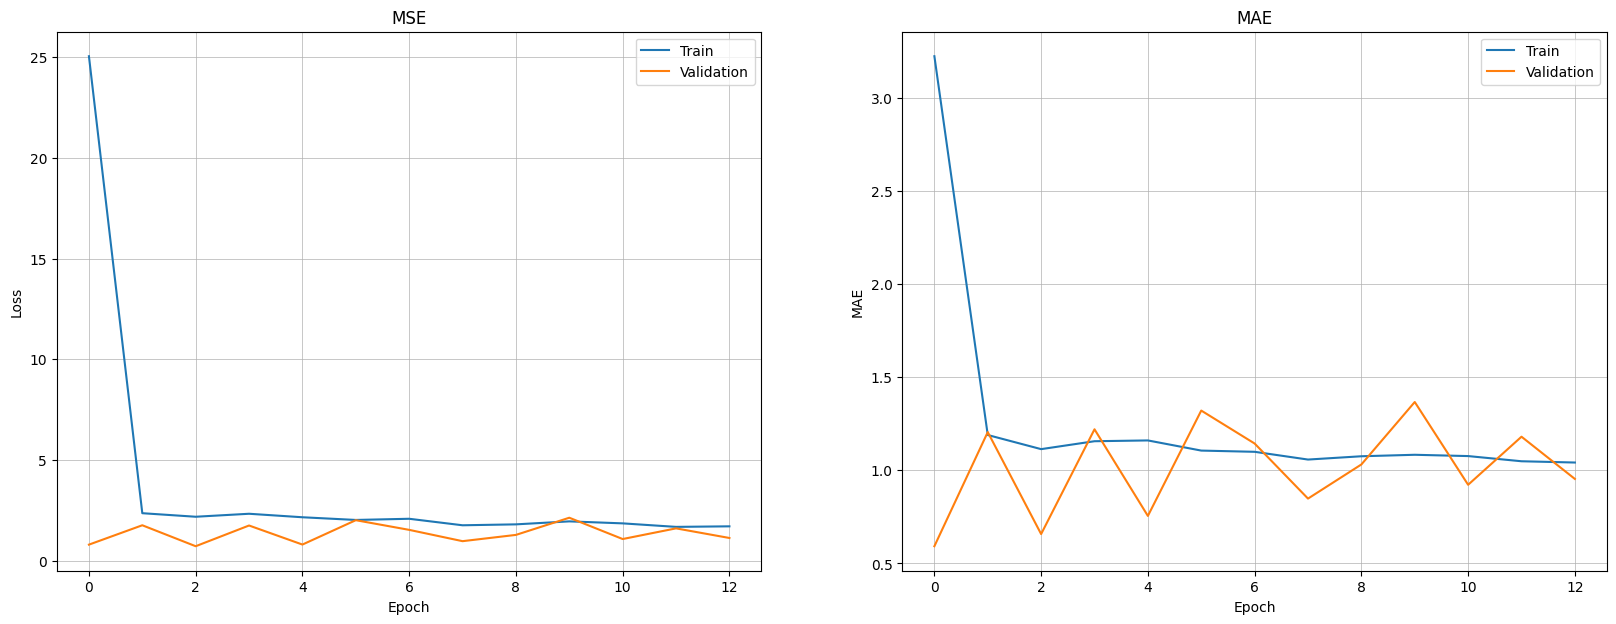

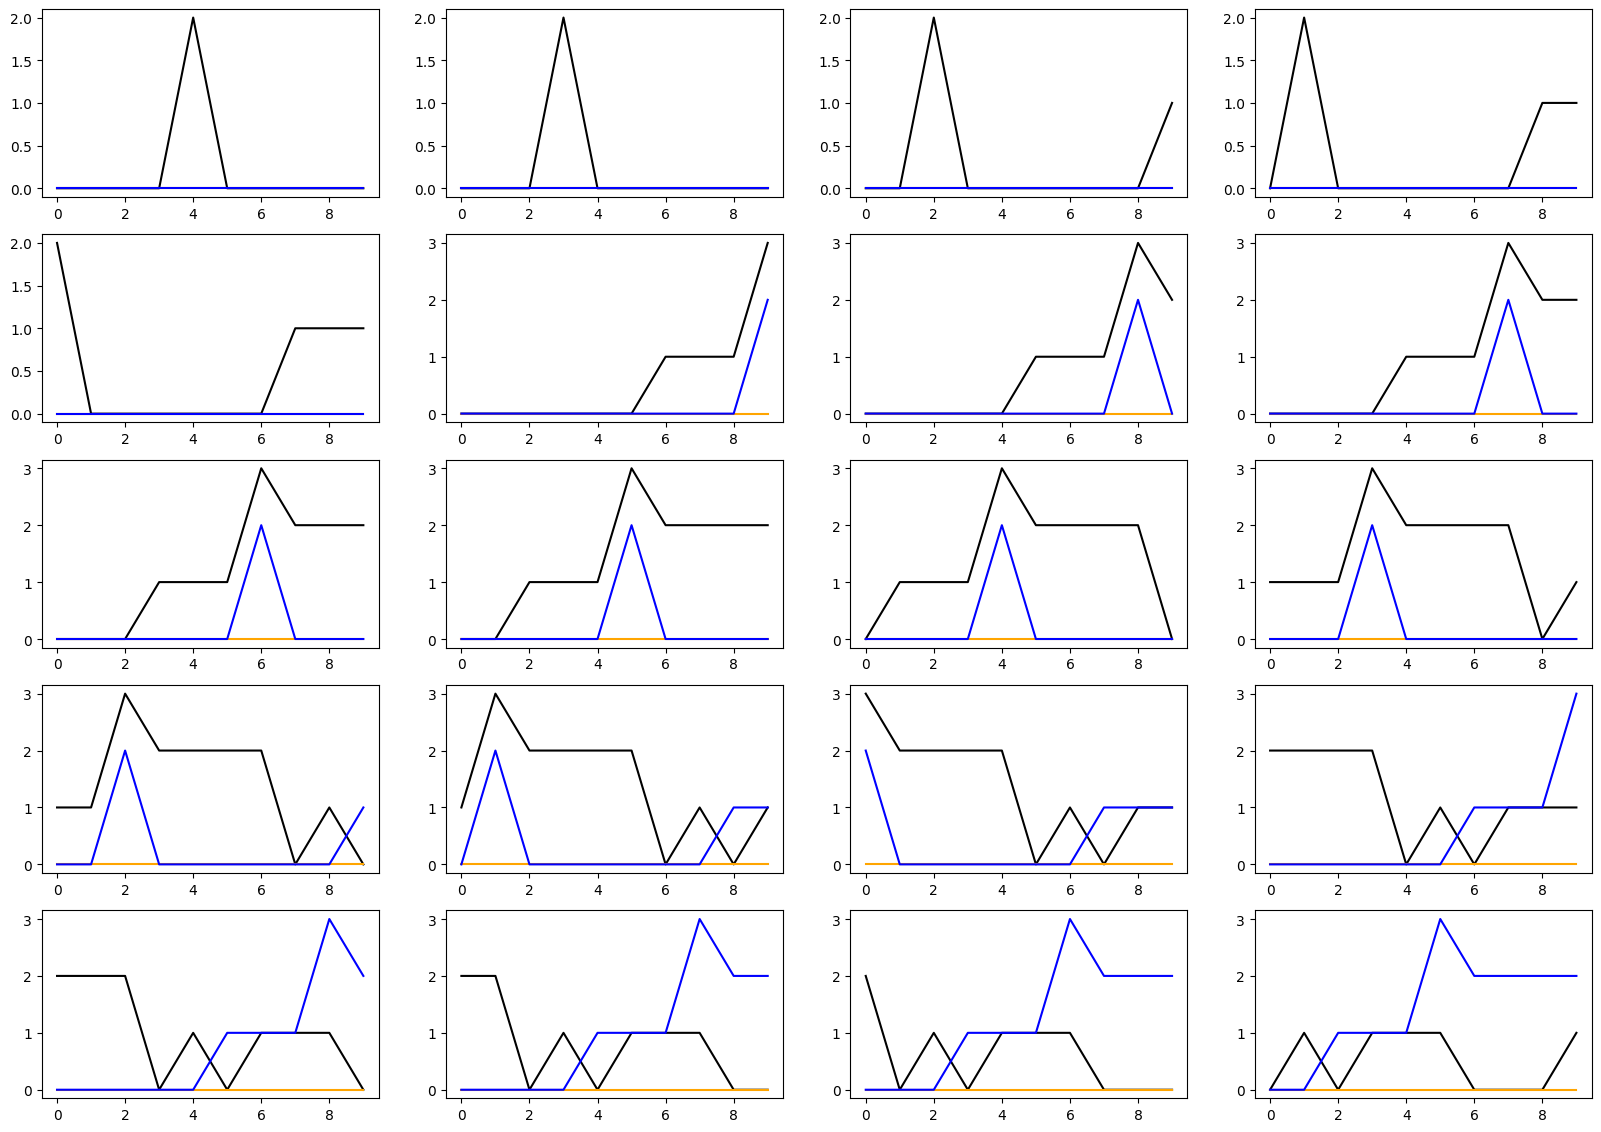

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj4/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj4/assets


******
 Initiating procedure on geohash gcpvj1
 ******
2/2 [==============================] - 0s 13ms/step - loss: 1.1212 - mae: 0.7788
The LSTM MAE on the test set is equal to 0.77 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :1.12 %
2/2 [==============================] - 0s 8ms/step


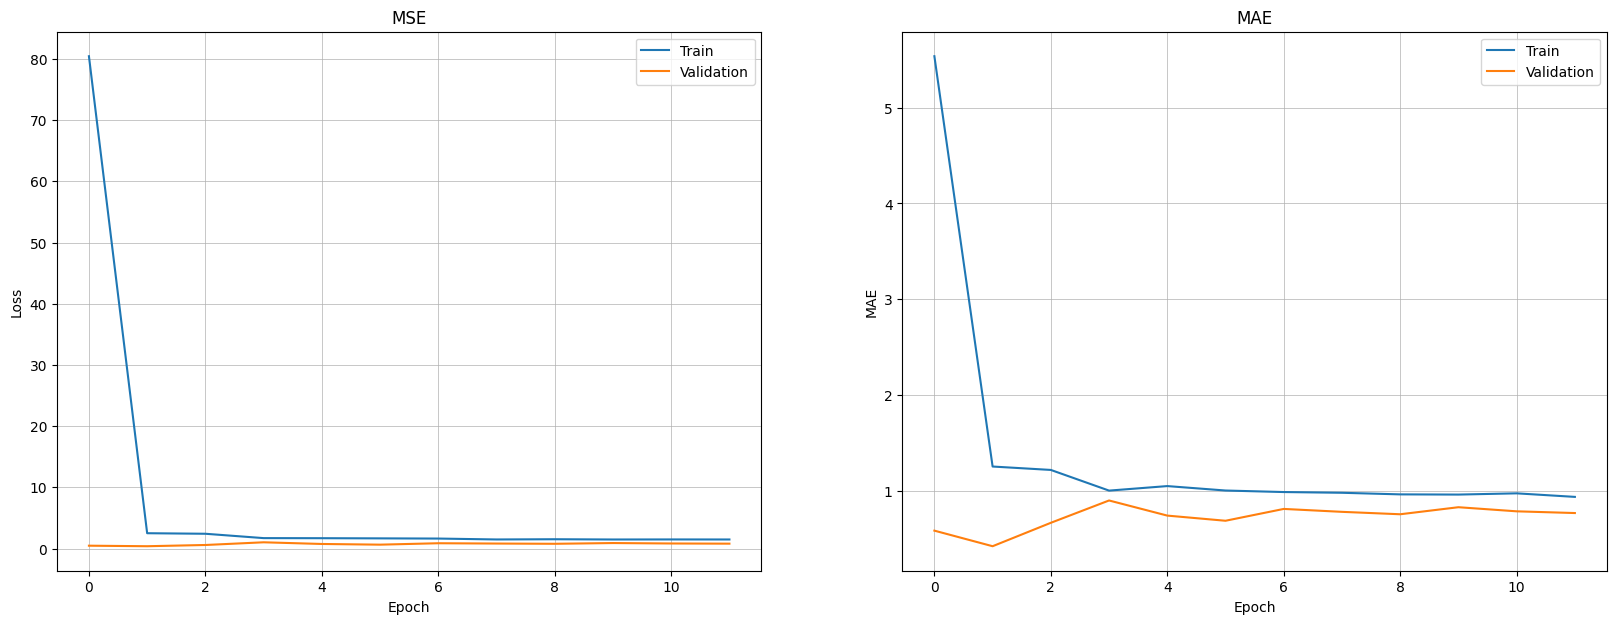

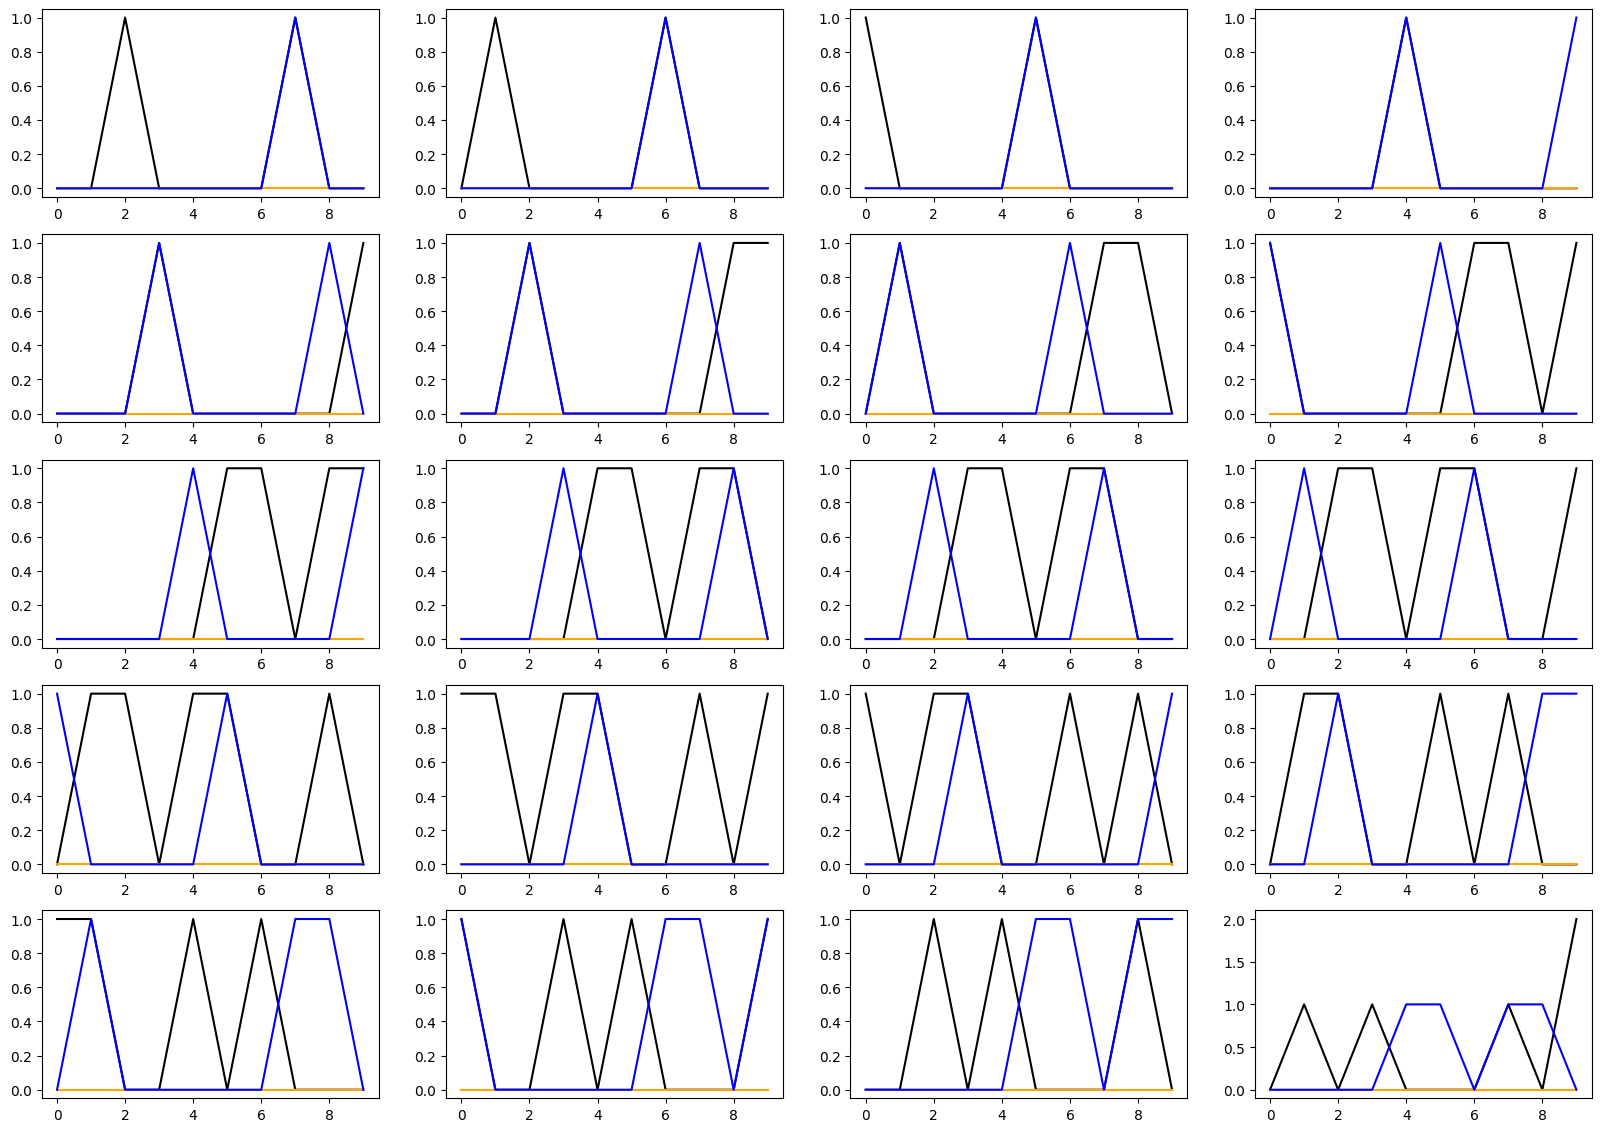

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj1/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj1/assets


******
 Initiating procedure on geohash gcpuv2
 ******
2/2 [==============================] - 0s 14ms/step - loss: 2.0303 - mae: 1.0424
The LSTM MAE on the test set is equal to 0.91 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :12.5 %
2/2 [==============================] - 0s 5ms/step


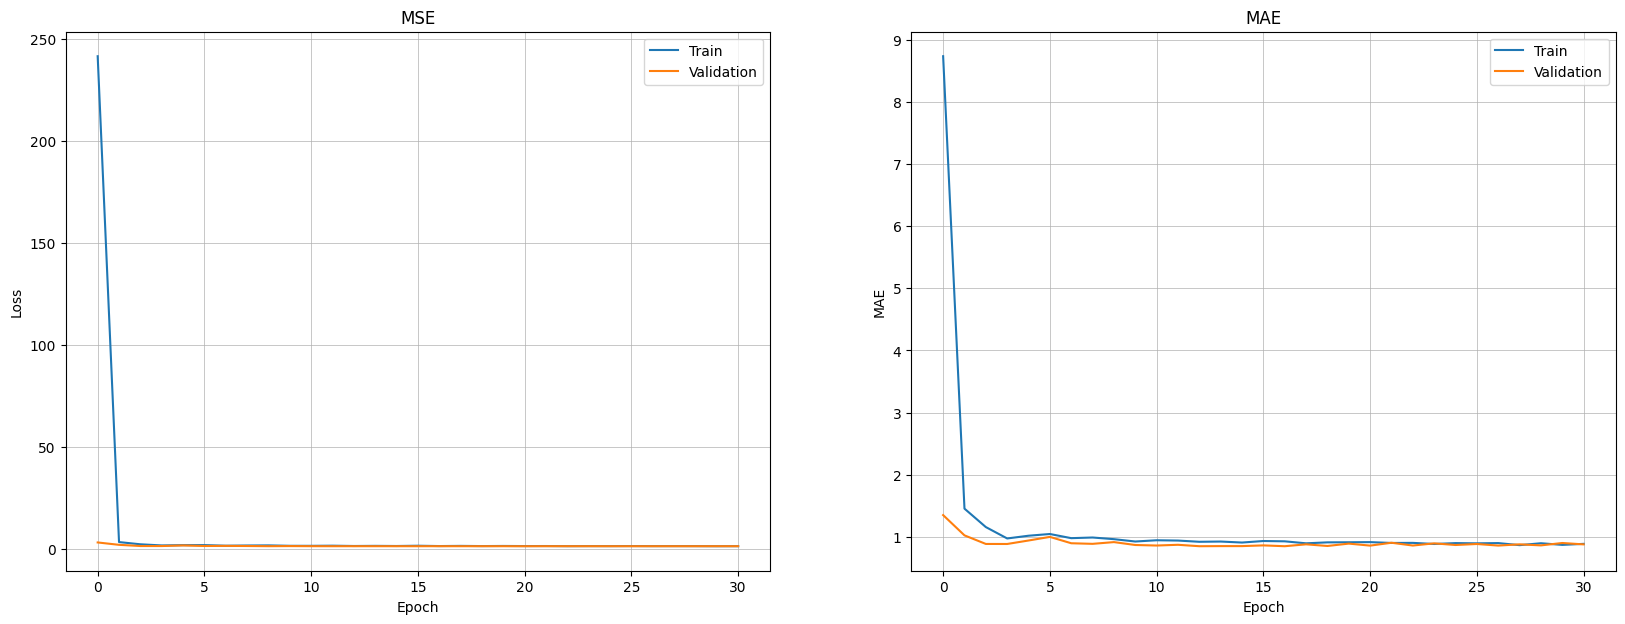

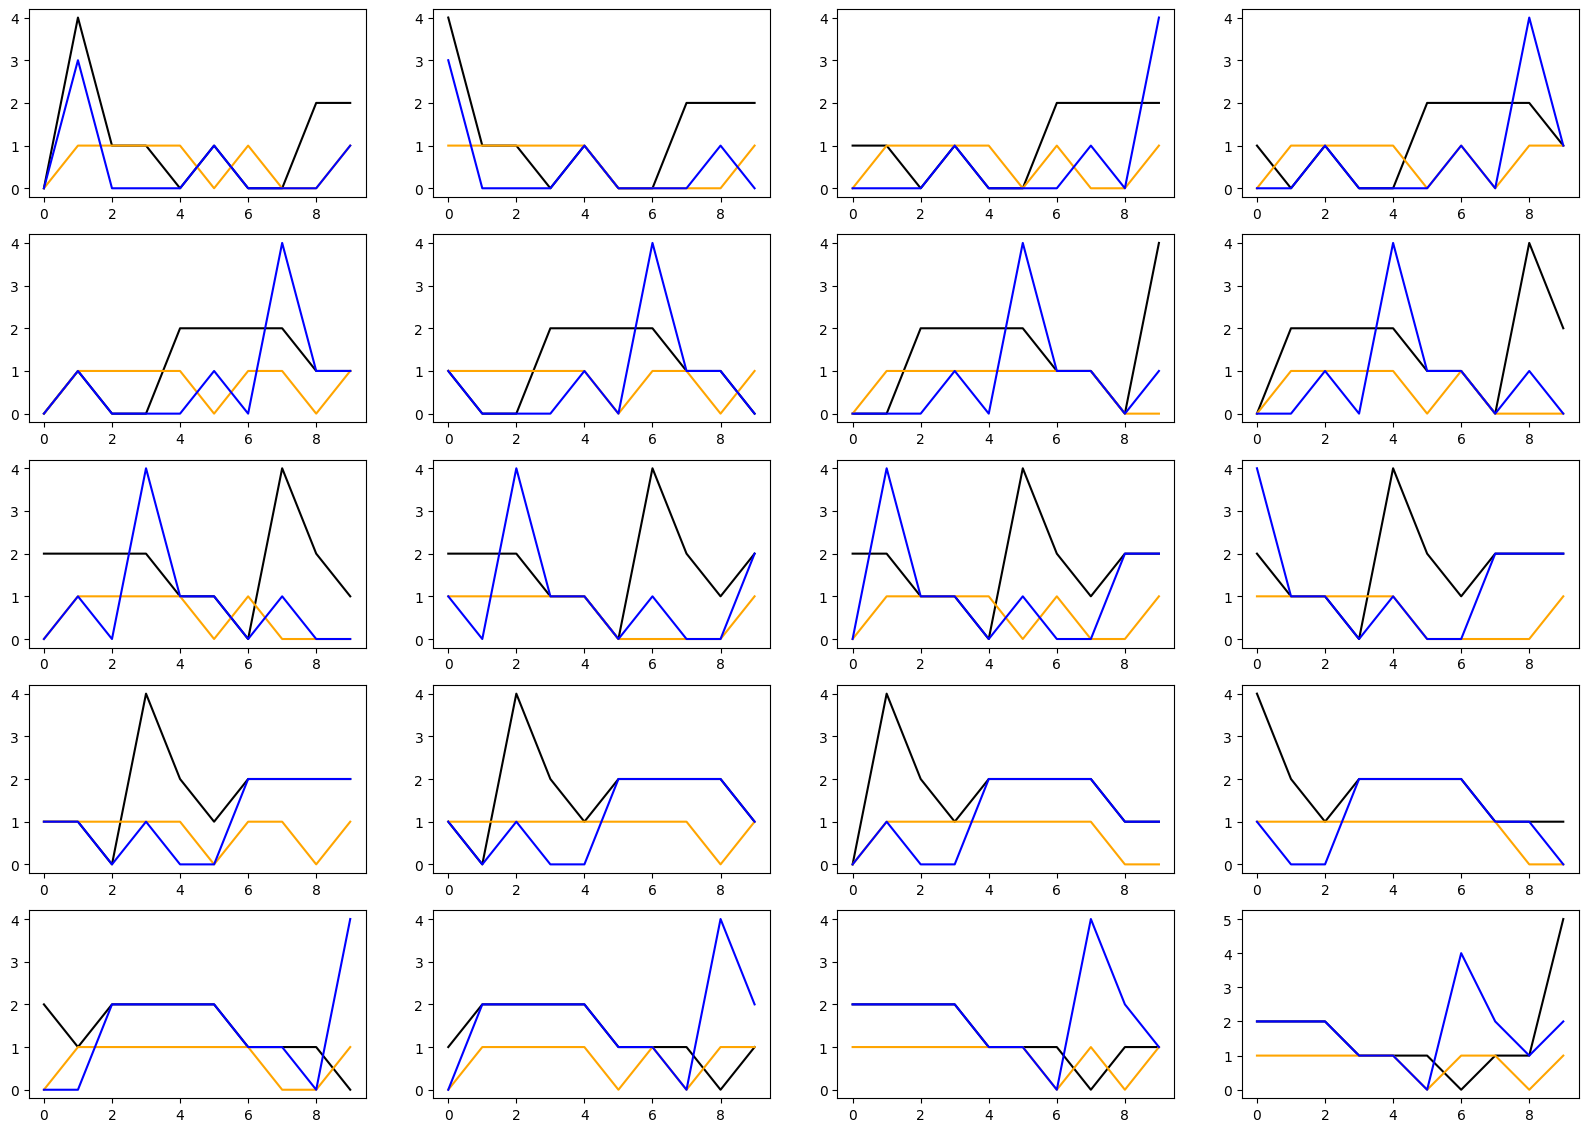

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpuv2/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpuv2/assets


In [20]:
for hash in geohash_list:
    print(f'******\n Initiating procedure on geohash {hash}\n ******')
    #filtering the data by hash and creating the time series
    filtered_data=df_accidents[df_accidents['geohash']==hash]
    time_series=data_for_analysis(filtered_data,'W')
    #creating the folds within the time series and selecting the last fold
    folds=mlmodel.get_folds(time_series,FOLD_LENGTH,FOLD_STRIDE)
    fold=folds[-1]
    #splitting the folds in train and test
    (fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
    #creating the sequences
    X_train, y_train = mlmodel.get_X_y_strides(fold_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
    X_test, y_test = mlmodel.get_X_y_strides(fold_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
    #initiating and trining the model
    model = mlmodel.init_model(X_train)
    model, history = mlmodel.fit_model(model,X_train,y_train,verbose=0)
    mlmodel.plot_history(history);
    res=model.evaluate(X_test,y_test)
    #initiating the baseline model
    baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
    baseline_score = baseline_model.evaluate(X_test, y_test)
    
    print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
    print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = :{round((1 - (res[1]/baseline_score[1]))*100,2)} %")
    #generating predictions
    y_pred=model.predict(X_test)
    y_bas_pred=baseline_model.predict(X_test)
    mlmodel.plot_predictions(y_test, y_pred, y_bas_pred)
    #saving the model and the last week of 2021 for the final prediction
    model.save(f'../uk_road_safety/model/{hash}')
    X=X_test[-1]
    np.save(os.path.join('../uk_road_safety/data',f'X_{hash}.npy'), X)
    

True